# 1) Imports and data loading


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import json

In [56]:
try:
    nltk.data.find('tokenizers/punkt')
    print("Punkt tokenizer already downloaded.")
except LookupError:
    nltk.download('punkt')
    print("Punkt tokenizer downloaded successfully.")
    
try:
    nltk.data.find('tokenizers/punkt_tab/english/')
    print("Punkt tokenizer (tabulated English) already downloaded.")
except LookupError:
    nltk.download('punkt_tab')
    print("Punkt tokenizer (tabulated English) downloaded successfully.")

try:
    nltk.data.find('corpora/stopwords')
    print("Stopwords corpus already downloaded.")
except LookupError:
    nltk.download('stopwords')
    print("Stopwords corpus downloaded successfully.")

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
    print("Averaged Perceptron Tagger already downloaded.")
except LookupError:
    nltk.download('averaged_perceptron_tagger')
    print("Averaged Perceptron Tagger downloaded successfully.")
    
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    print("Averaged Perceptron Tagger (English) already downloaded.")
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')
    print("Averaged Perceptron Tagger (English) downloaded successfully.")


Punkt tokenizer already downloaded.
Punkt tokenizer (tabulated English) already downloaded.
Stopwords corpus already downloaded.
Averaged Perceptron Tagger already downloaded.
Averaged Perceptron Tagger (English) already downloaded.


In [3]:
print(nltk.data.path)

['/Users/barissimsek/nltk_data', '/Users/barissimsek/Desktop/NLP praktikum/NLP-SS25-Machine-Generated-Text-Detection/.venv/nltk_data', '/Users/barissimsek/Desktop/NLP praktikum/NLP-SS25-Machine-Generated-Text-Detection/.venv/share/nltk_data', '/Users/barissimsek/Desktop/NLP praktikum/NLP-SS25-Machine-Generated-Text-Detection/.venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [5]:
data_path = "./data/subtaskA_dev_monolingual.jsonl"
df = pd.read_json(data_path, lines=True)
df.head()

,text,label,model,source,id
0,Giving gifts should always be enjoyable. Howe...,1,bloomz,wikihow,0
1,Yveltal (Japanese: ユベルタル) is one of the main a...,1,bloomz,wikihow,1
2,If you'd rather not annoy others by being rude...,1,bloomz,wikihow,2
3,If you're interested in visiting gravesite(s) ...,1,bloomz,wikihow,3
4,The following are some tips for becoming succe...,1,bloomz,wikihow,4


In [6]:
df['source'].value_counts()

source
wikihow      1000
wikipedia    1000
reddit       1000
arxiv        1000
peerread     1000
Name: count, dtype: int64

In [7]:
df['model'].value_counts()

model
bloomz    2500
human     2500
Name: count, dtype: int64

In [8]:
df['label'].value_counts()

label
1    2500
0    2500
Name: count, dtype: int64

# 2) Dividing the data into human and machine generated text


In [9]:
human_df = df[df['label'] == 0].copy()
machine_df = df[df['label'] == 1].copy()

# 3) EDA


## 3.1) Basic Text Statistics


In [10]:
def analyze_text_length_distribution(df_to_analyze: pd.DataFrame, df_name: str) -> pd.DataFrame:
    temp_df = df_to_analyze.copy()
    temp_df['text_length'] = temp_df['text'].apply(len)

    plt.figure(figsize=(10, 6))
    sns.histplot(temp_df['text_length'], bins=50)
    plt.title(f'Distribution of Text Lengths for {df_name} Data')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    return temp_df['text_length'].describe().to_frame()

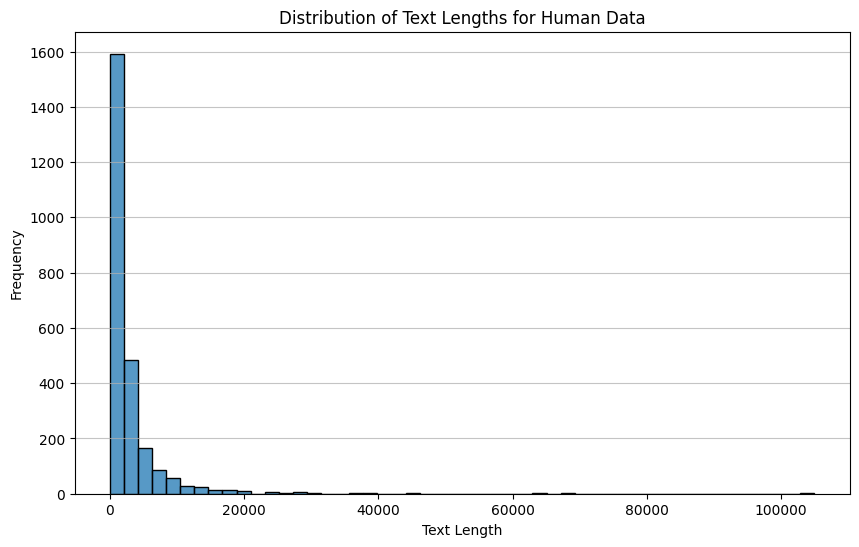

         text_length
count    2500.000000
mean     3127.142800
std      4880.068497
min        32.000000
25%      1196.750000
50%      1692.000000
75%      3069.000000
max    104923.000000


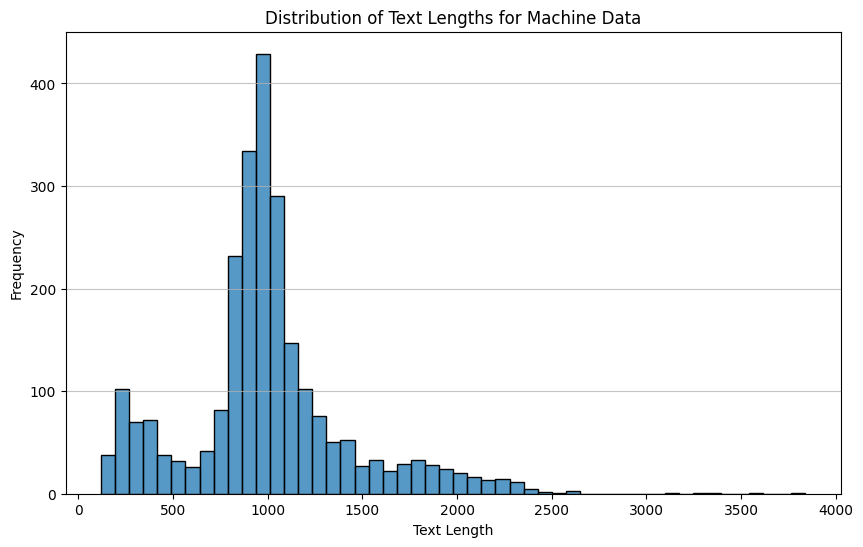

       text_length
count  2500.000000
mean    998.879200
std     436.264819
min     119.000000
25%     832.000000
50%     971.000000
75%    1124.250000
max    3840.000000


In [17]:
human_length_stats = analyze_text_length_distribution(human_df, "Human")
print(human_length_stats)
machine_length_stats = analyze_text_length_distribution(machine_df, "Machine")
print(machine_length_stats)

In [29]:
from nltk.tokenize import sent_tokenize

def analyze_sentence_length_distribution(df_to_analyze: pd.DataFrame, df_name: str) -> pd.DataFrame:
    temp_df = df_to_analyze.copy()
    all_sentence_lengths = [
        len(sentence) for text in temp_df['text'] for sentence in sent_tokenize(text)
    ]
    sentence_lengths_series = pd.Series(all_sentence_lengths)

    
    plt.figure(figsize=(12, 7))
    sns.histplot(sentence_lengths_series, bins=100, kde=True, color='lightcoral')
    plt.title(f'Distribution of Sentence Lengths for {df_name} Data (NLTK)')
    plt.xlabel('Sentence Length (characters)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    return sentence_lengths_series.describe().to_frame()

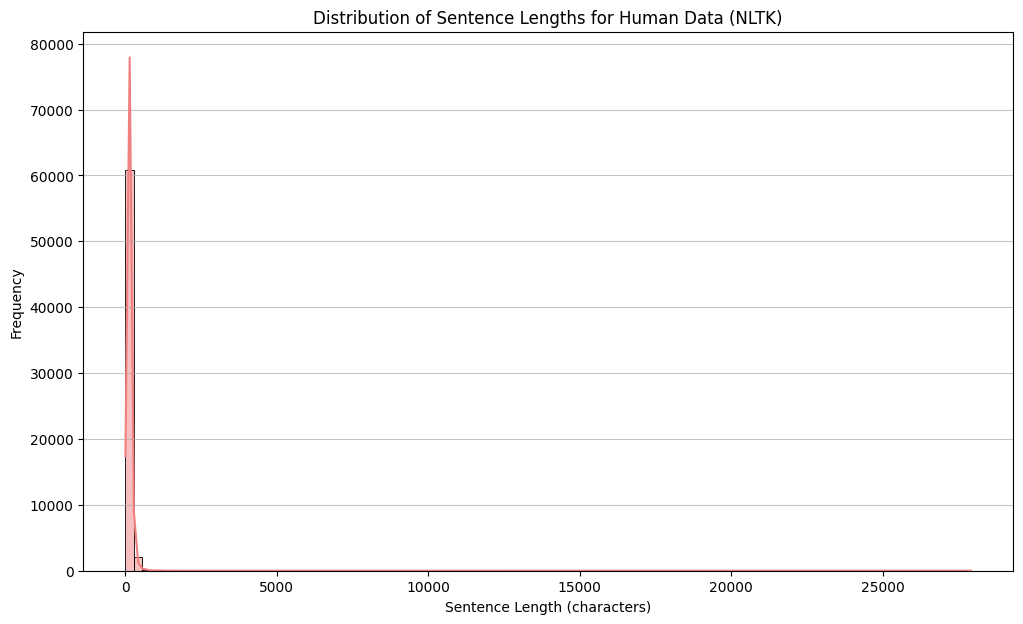

                  0
count  63201.000000
mean     122.318887
std      174.439619
min        1.000000
25%       68.000000
50%      104.000000
75%      152.000000
max    27907.000000


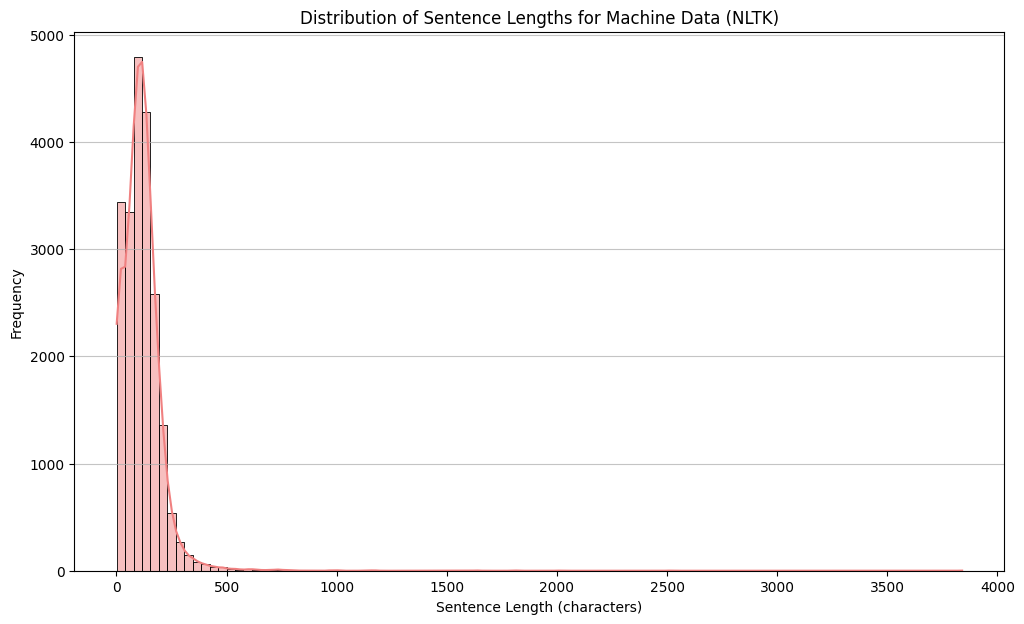

                  0
count  21081.000000
mean     116.849343
std       96.089740
min        1.000000
25%       62.000000
50%      108.000000
75%      154.000000
max     3840.000000


In [30]:
human_sentence_length_stats = analyze_sentence_length_distribution(human_df, "Human")
print(human_sentence_length_stats)
machine_sentence_length_stats = analyze_sentence_length_distribution(machine_df, "Machine")
print(machine_sentence_length_stats)

In [41]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

def analyze_unique_word_count_distribution(df_to_analyze: pd.DataFrame, df_name: str) -> pd.DataFrame:
    temp_df = df_to_analyze.copy()
    stop_words = set(stopwords.words('english'))

    def get_unique_word_count(text):
        if not isinstance(text, str):
            return 0

        words = word_tokenize(text.lower())
        filtered_words = [
            word for word in words if word.isalpha() and word not in stop_words
        ]
        return len(set(filtered_words))

    unique_word_counts_series = temp_df['text'].apply(get_unique_word_count)

    if unique_word_counts_series.empty or unique_word_counts_series.sum() == 0:
        return pd.DataFrame()

    plt.figure(figsize=(12, 7))
    sns.histplot(unique_word_counts_series, bins=50, kde=True, color='mediumseagreen')
    plt.title(f'Distribution of Unique Word Counts for {df_name} Data (NLTK)')
    plt.xlabel('Number of Unique Words (excluding stop words and punctuation)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    return unique_word_counts_series.describe().to_frame()

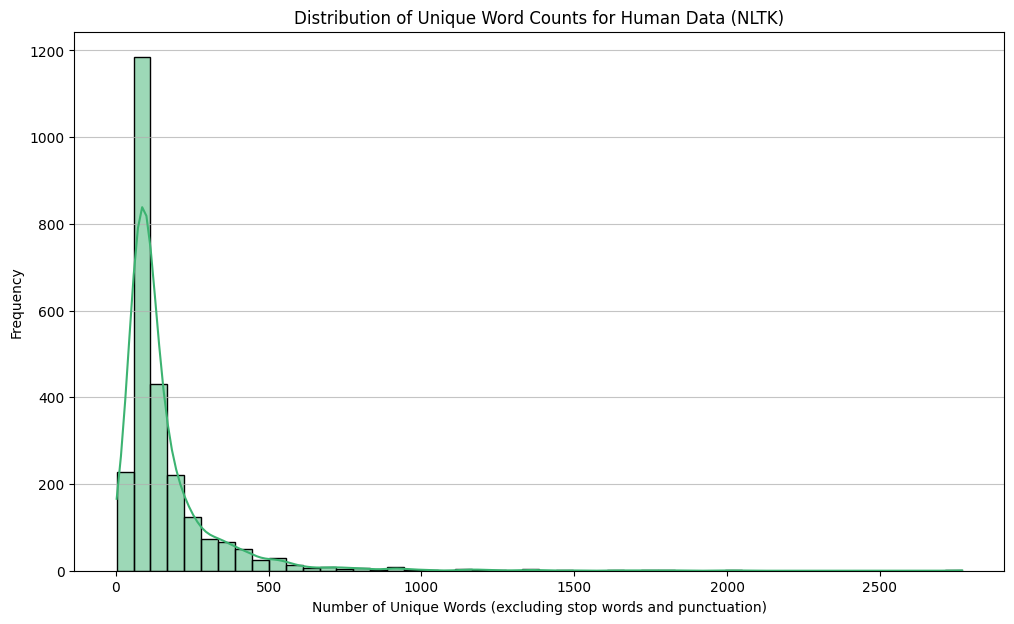

              text
count  2500.000000
mean    158.730800
std     173.114437
min       3.000000
25%      76.000000
50%     103.000000
75%     176.000000
max    2769.000000


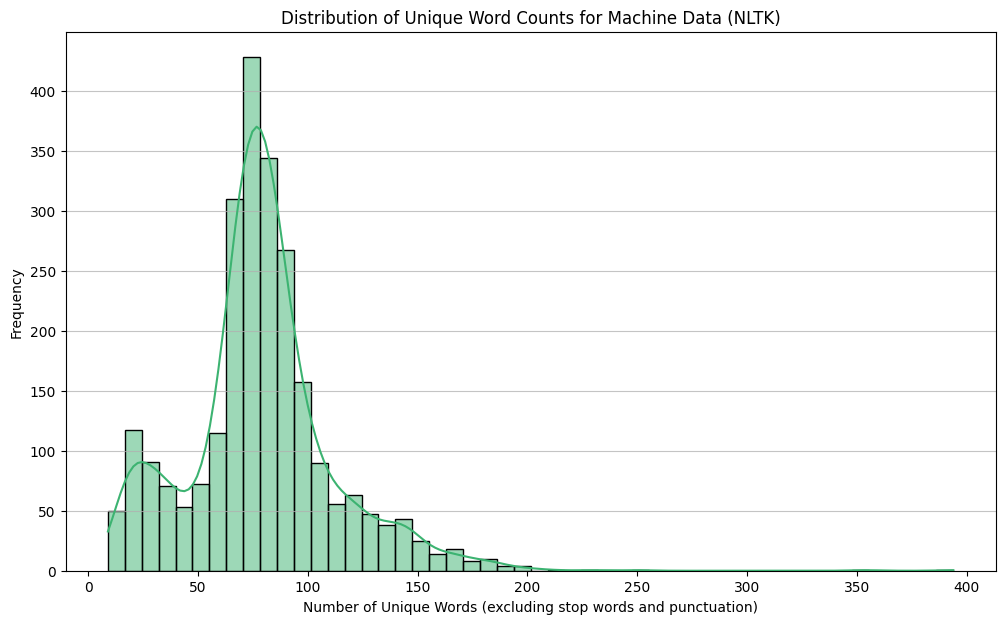

              text
count  2500.000000
mean     78.730000
std      33.623845
min       9.000000
25%      64.000000
50%      77.000000
75%      92.000000
max     394.000000


In [42]:
human_unique_word_stats = analyze_unique_word_count_distribution(human_df, "Human")
print(human_unique_word_stats)
machine_unique_word_stats = analyze_unique_word_count_distribution(machine_df, "Machine")
print(machine_unique_word_stats)

In [46]:
def analyze_lexical_diversity(df_to_analyze: pd.DataFrame, df_name: str) -> pd.DataFrame:
    temp_df = df_to_analyze.copy()

    lexical_diversities = []
    for text in temp_df['text']:
        words = word_tokenize(text.lower())
        filtered_words = [word for word in words if word.isalpha()]

        if len(filtered_words) > 0:
            ttr = len(set(filtered_words)) / len(filtered_words)
        else:
            ttr = 0.0

        lexical_diversities.append(ttr)

    lexical_diversities_series = pd.Series(lexical_diversities)

    plt.figure(figsize=(12, 7))
    sns.histplot(lexical_diversities_series, bins=30, kde=True, color='mediumpurple', stat='density')
    plt.title(f'Distribution of Lexical Diversity (Type-Token Ratio) for {df_name} Data')
    plt.xlabel('Lexical Diversity (Type-Token Ratio)')
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    return lexical_diversities_series.describe().to_frame()

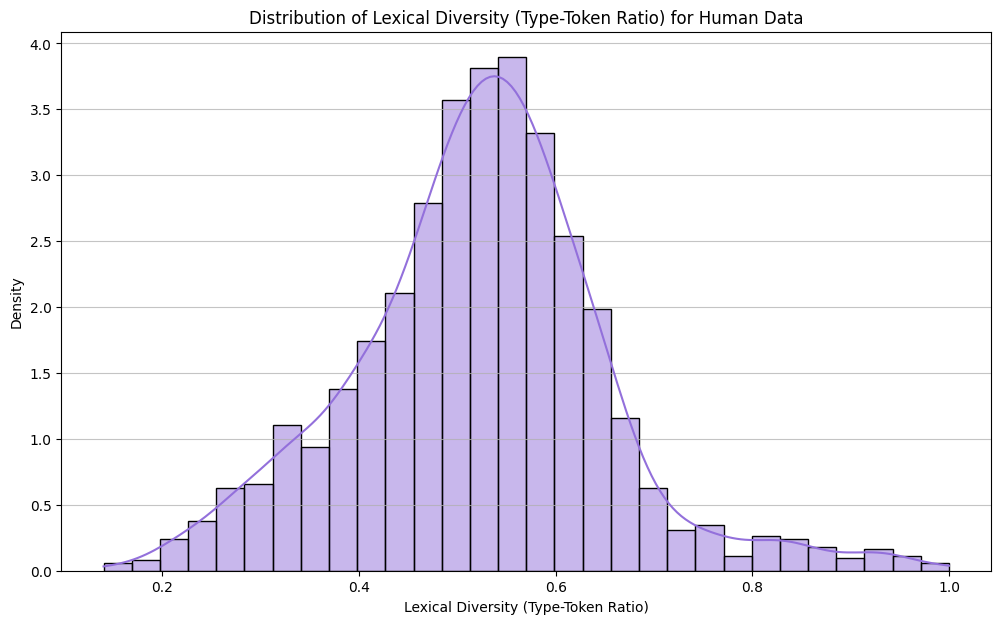

                 0
count  2500.000000
mean      0.521809
std       0.128571
min       0.140227
25%       0.447368
50%       0.526659
75%       0.593419
max       1.000000


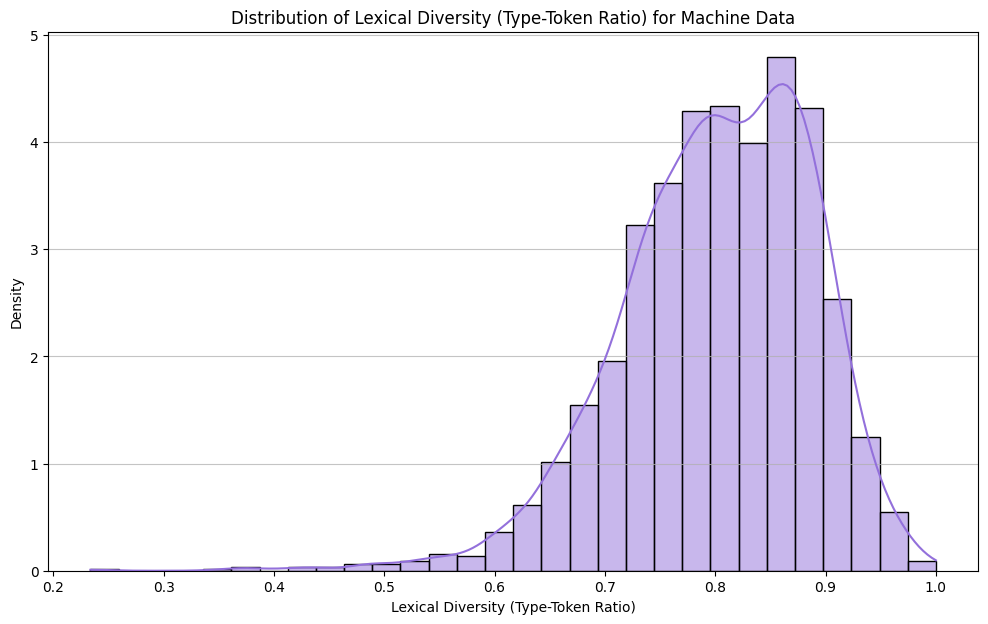

                 0
count  2500.000000
mean      0.801585
std       0.087149
min       0.233645
25%       0.747380
50%       0.808447
75%       0.867188
max       1.000000


In [47]:
human_lexical_diversity_stats = analyze_lexical_diversity(human_df, "Human")
print(human_lexical_diversity_stats)
machine_lexical_diversity_stats = analyze_lexical_diversity(machine_df, "Machine")
print(machine_lexical_diversity_stats)

## 3.2) Word Frequency Analysis


In [49]:
def analyze_most_common_words(df_to_analyze: pd.DataFrame, df_name: str, top_n: int = 20) -> pd.DataFrame:
    all_filtered_words = []
    stop_words = set(stopwords.words('english'))

    for text in df_to_analyze['text']:
        if not isinstance(text, str):
            continue
        words = word_tokenize(text.lower())
        filtered_words = [
            word for word in words if word.isalpha() and word not in stop_words
        ]
        all_filtered_words.extend(filtered_words)

    if not all_filtered_words:
        print(f"No meaningful words found in {df_name} data to analyze common words.")
        return pd.DataFrame(columns=['Word', 'Frequency'])

    fdist = FreqDist(all_filtered_words)
    most_common = fdist.most_common(top_n)

    most_common_df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])

    plt.figure(figsize=(14, 8))
    sns.barplot(
        x='Frequency',
        y='Word',
        data=most_common_df,
        palette='viridis'
    )
    plt.title(f'Top {top_n} Most Common Words in {df_name} Data (Excluding Stop Words)')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.grid(axis='x', alpha=0.75)
    plt.show()

    return most_common_df

/var/folders/ms/770syfqj7xb3v9nj8w418mhc0000gn/T/ipykernel_29593/54272987.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


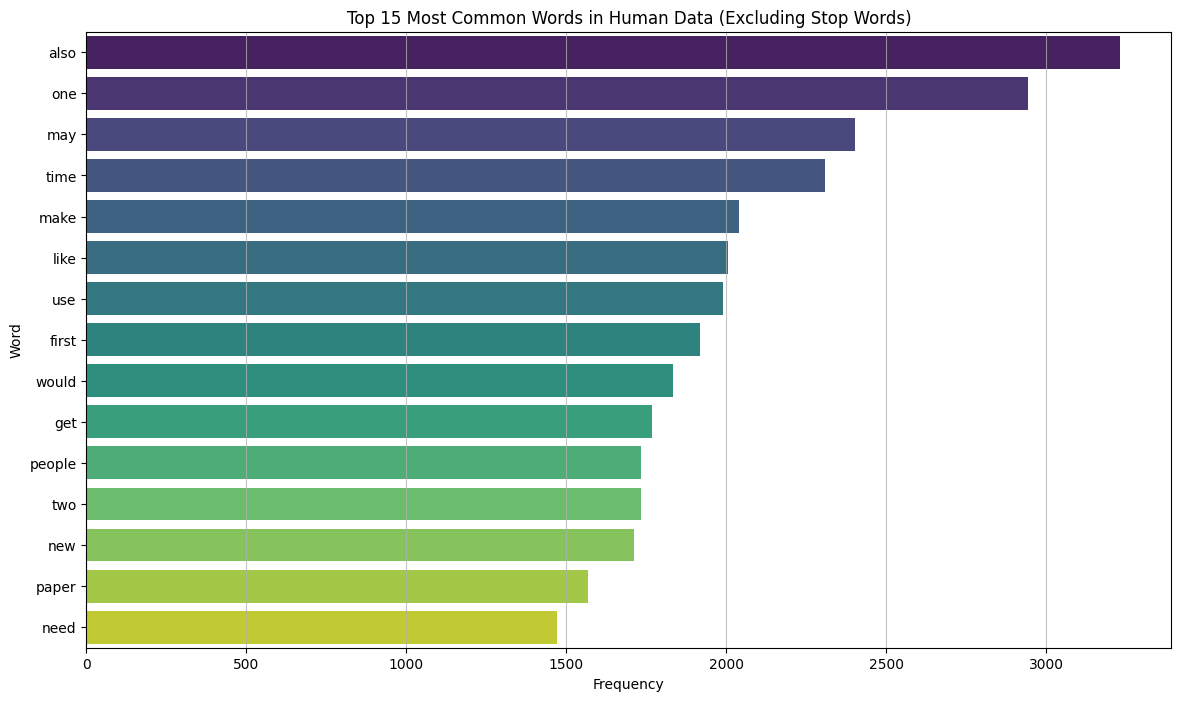

      Word  Frequency
0     also       3230
1      one       2943
2      may       2402
3     time       2308
4     make       2040
5     like       2004
6      use       1990
7    first       1919
8    would       1834
9      get       1767
10  people       1734
11     two       1734
12     new       1711
13   paper       1567
14    need       1470


/var/folders/ms/770syfqj7xb3v9nj8w418mhc0000gn/T/ipykernel_29593/54272987.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


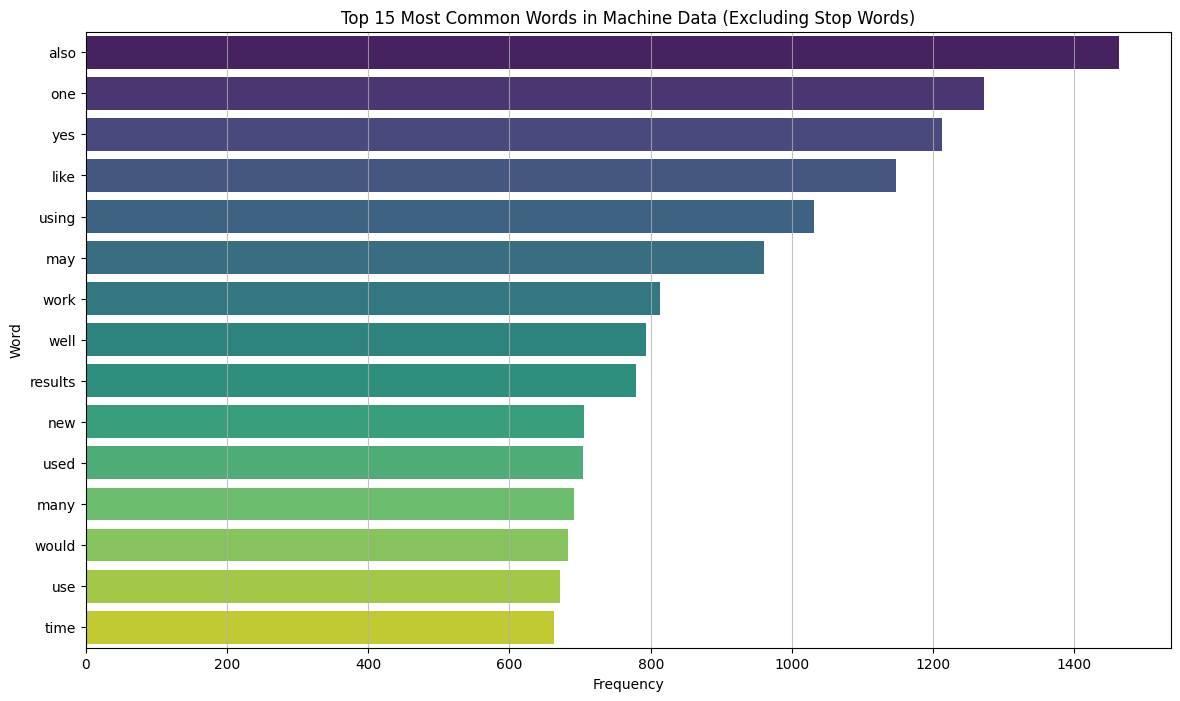

       Word  Frequency
0      also       1463
1       one       1272
2       yes       1212
3      like       1148
4     using       1031
5       may        961
6      work        813
7      well        793
8   results        779
9       new        706
10     used        704
11     many        691
12    would        683
13      use        671
14     time        663


In [50]:
human_most_common_words = analyze_most_common_words(human_df, "Human", top_n=15)
print(human_most_common_words.head())
machine_most_common_words = analyze_most_common_words(machine_df, "Machine", top_n=15)
print(machine_most_common_words.head())

## 3.3) Part of Speech Analysis


In [25]:
from nltk.tag import pos_tag

def analyze_pos_distribution(df_to_analyze: pd.DataFrame, df_name: str, top_n_tags: int = 15) -> pd.DataFrame:
    all_pos_tags = []

    for text in df_to_analyze['text']:
        if not isinstance(text, str):
            continue
        words = word_tokenize(text.lower()) 
        tags = pos_tag(words)
        just_tags = [tag for word, tag in tags if word.isalpha()]

        all_pos_tags.extend(just_tags)

    if not all_pos_tags:
        print(f"No valid POS tags found in {df_name} data to analyze distribution.")
        return pd.DataFrame(columns=['POS Tag', 'Frequency'])

    fdist_pos = FreqDist(all_pos_tags)
    pos_percentages = {tag: count / len(all_pos_tags) for tag, count in fdist_pos.items()}

    pos_dist_df = pd.DataFrame(
        list(pos_percentages.items()),
        columns=['POS Tag', 'Percentage']
    ).sort_values(by='Percentage', ascending=False)

    pos_dist_for_plot = pos_dist_df.head(top_n_tags)


    plt.figure(figsize=(14, 8))
    sns.barplot(
        x='Percentage',
        y='POS Tag',
        data=pos_dist_for_plot,
        palette='magma'
    )
    
    plt.title(f'Top {top_n_tags} Part-of-Speech Tag Distribution in {df_name} Data')
    plt.xlabel('Percentage of Total Tags')
    plt.ylabel('POS Tag')
    plt.grid(axis='x', alpha=0.75)
    plt.xlim(0, pos_dist_for_plot['Percentage'].max() * 1.1)
    plt.show()

    return pos_dist_df 

/var/folders/ms/770syfqj7xb3v9nj8w418mhc0000gn/T/ipykernel_29593/2004651976.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


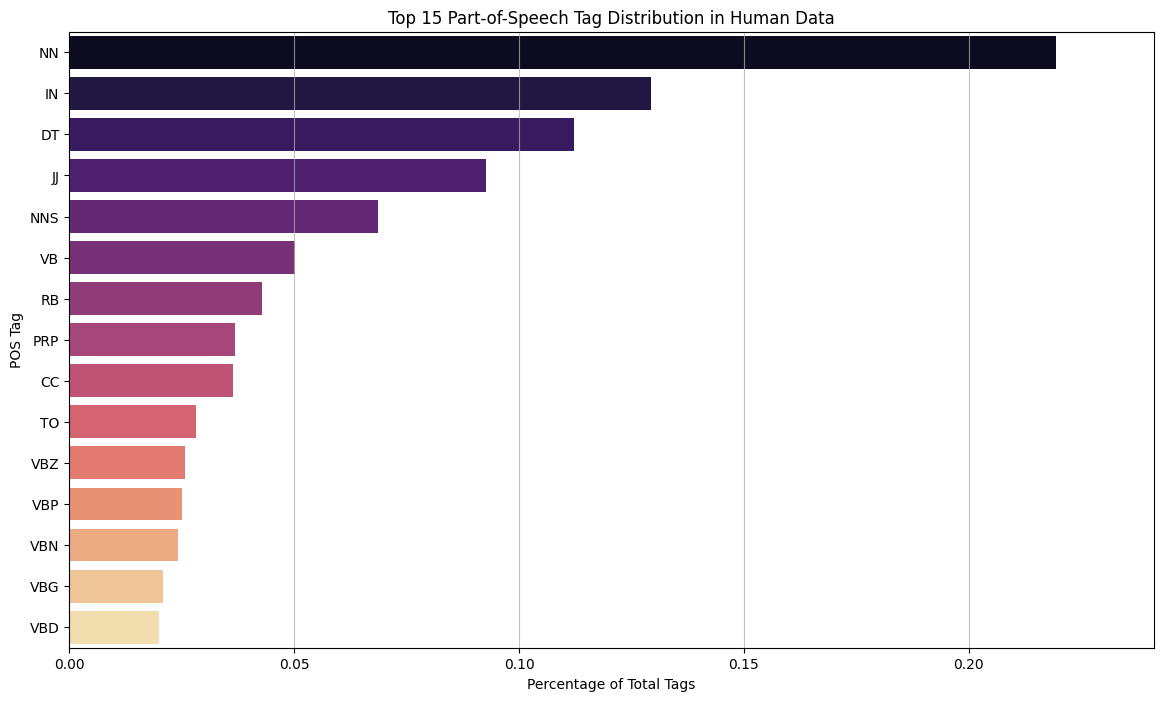

   POS Tag    Percentage
6       NN  2.192453e-01
0       IN  1.293060e-01
5       DT  1.121413e-01
8       JJ  9.275042e-02
9      NNS  6.859531e-02
3       VB  5.022632e-02
4       RB  4.292901e-02
1      PRP  3.677415e-02
7       CC  3.640699e-02
12      TO  2.823960e-02
10     VBZ  2.584787e-02
15     VBP  2.507339e-02
18     VBN  2.419768e-02
14     VBG  2.085954e-02
23     VBD  2.006739e-02
2       MD  1.606885e-02
20    PRP$  1.556512e-02
16     WDT  5.664792e-03
11      CD  5.390028e-03
25     WRB  5.014839e-03
29     JJR  3.927032e-03
21      RP  3.874811e-03
17      WP  2.733979e-03
13     JJS  2.231049e-03
24     RBR  1.820510e-03
30      EX  1.732136e-03
32      FW  1.099055e-03
27     RBS  6.531663e-04
22     NNP  5.776464e-04
19     PDT  5.752362e-04
28       $  1.205104e-04
26      UH  9.881852e-05
31     SYM  8.837428e-05
33     WP$  8.435727e-05
34    NNPS  1.606805e-05
35     POS  1.606805e-06
36      ``  8.034026e-07
37      ''  8.034026e-07


/var/folders/ms/770syfqj7xb3v9nj8w418mhc0000gn/T/ipykernel_29593/2004651976.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


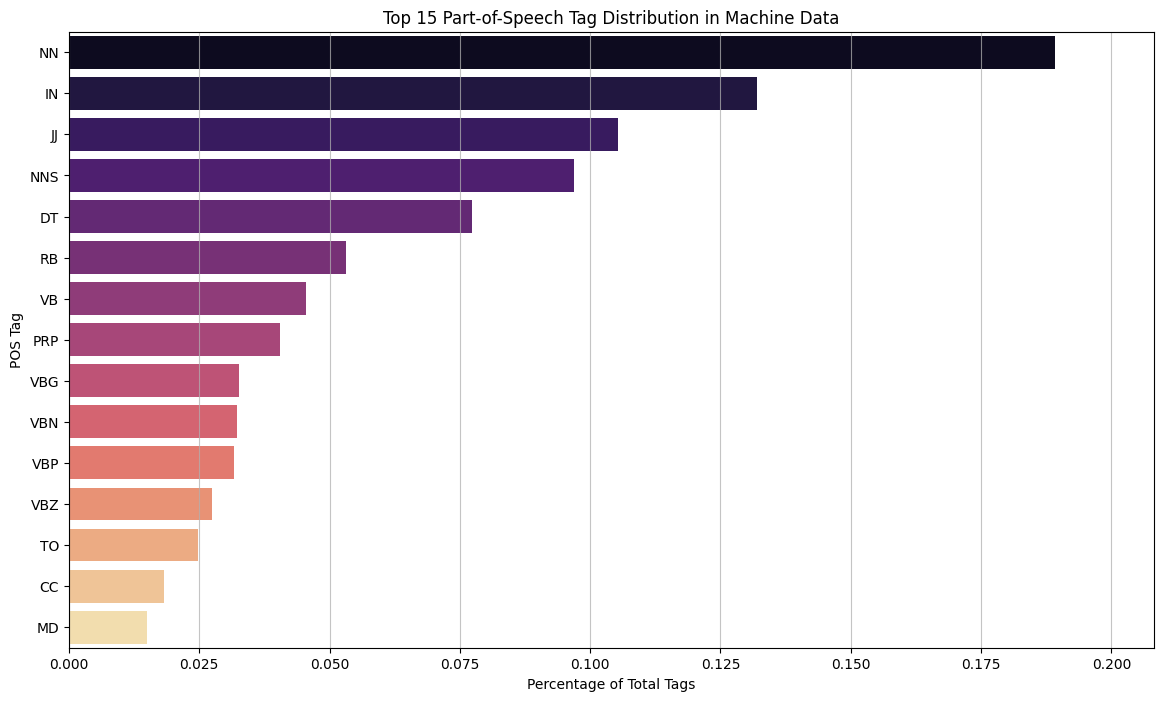

   POS Tag  Percentage
10      NN    0.189235
13      IN    0.131921
5       JJ    0.105284
1      NNS    0.096839
9       DT    0.077243
3       RB    0.053228
4       VB    0.045398
6      PRP    0.040521
0      VBG    0.032702
21     VBN    0.032306
19     VBP    0.031728
22     VBZ    0.027458
8       TO    0.024690
15      CC    0.018292
2       MD    0.014960
20    PRP$    0.013797
23     VBD    0.012748
7      WRB    0.011655
17     WDT    0.006504
14      CD    0.006219
16     JJR    0.005414
12      WP    0.004322
26      EX    0.003768
11      RP    0.003579
32      UH    0.002727
18     JJS    0.001844
24     RBR    0.001835
28      FW    0.001375
27     RBS    0.000751
30     NNP    0.000697
29     PDT    0.000380
25     WP$    0.000230
33       $    0.000211
31     SYM    0.000130
34    NNPS    0.000005
35     POS    0.000003


In [57]:
human_pos_distribution = analyze_pos_distribution(human_df, "Human", top_n_tags=15)
print(human_pos_distribution)
machine_pos_distribution = analyze_pos_distribution(machine_df, "Machine", top_n_tags=15)
print(machine_pos_distribution)

## 3.4) Sentence Structure Analysis


In [58]:
import string

def analyze_punctuation_usage(df_to_analyze: pd.DataFrame, df_name: str, top_n_punct: int = 10) -> pd.DataFrame:
    all_punctuation = []
    punctuation_chars = set(string.punctuation)

    for text in df_to_analyze['text']:
        if not isinstance(text, str):
            continue
        tokens = word_tokenize(text)
        found_punct = [token for token in tokens if token in punctuation_chars]
        all_punctuation.extend(found_punct)

    if not all_punctuation:
        print(f"No punctuation found in {df_name} data to analyze usage.")
        return pd.DataFrame(columns=['Punctuation', 'Frequency'])

    fdist_punct = nltk.probability.FreqDist(all_punctuation)
    most_common_punct = fdist_punct.most_common(top_n_punct)

    most_common_punct_df = pd.DataFrame(most_common_punct, columns=['Punctuation', 'Frequency'])

    plt.figure(figsize=(12, 7))
    sns.barplot(
        x='Frequency',
        y='Punctuation',
        data=most_common_punct_df,
        palette='rocket'
    )
    plt.title(f'Top {top_n_punct} Punctuation Usage in {df_name} Data')
    plt.xlabel('Frequency')
    plt.ylabel('Punctuation Mark')
    plt.grid(axis='x', alpha=0.75)
    plt.show()

    return most_common_punct_df

/var/folders/ms/770syfqj7xb3v9nj8w418mhc0000gn/T/ipykernel_29593/2796139074.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


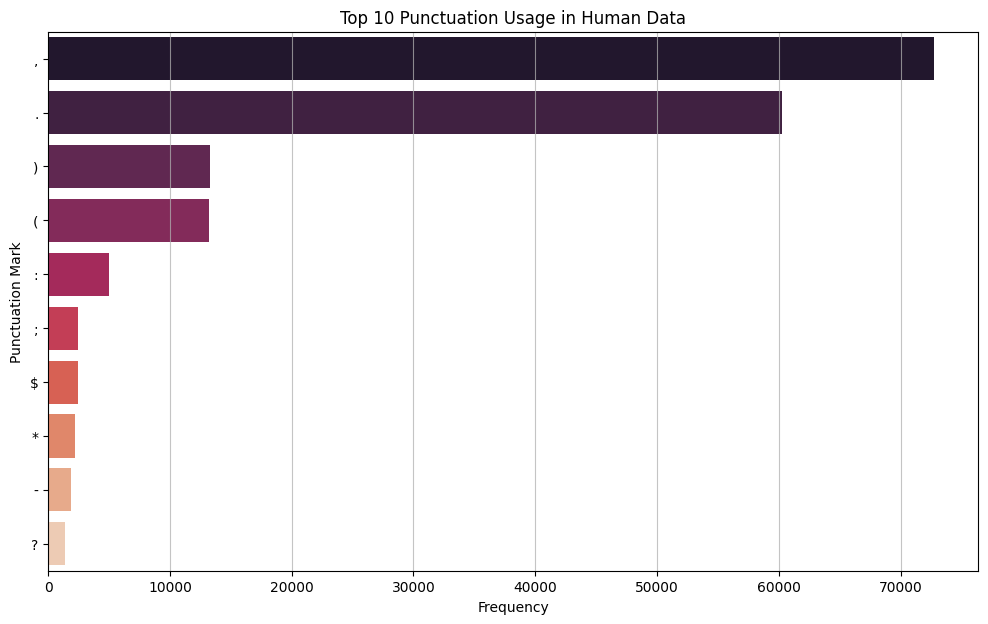

  Punctuation  Frequency
0           ,      72737
1           .      60296
2           )      13328
3           (      13190
4           :       4965
5           ;       2471
6           $       2466
7           *       2245
8           -       1842
9           ?       1409


/var/folders/ms/770syfqj7xb3v9nj8w418mhc0000gn/T/ipykernel_29593/2796139074.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


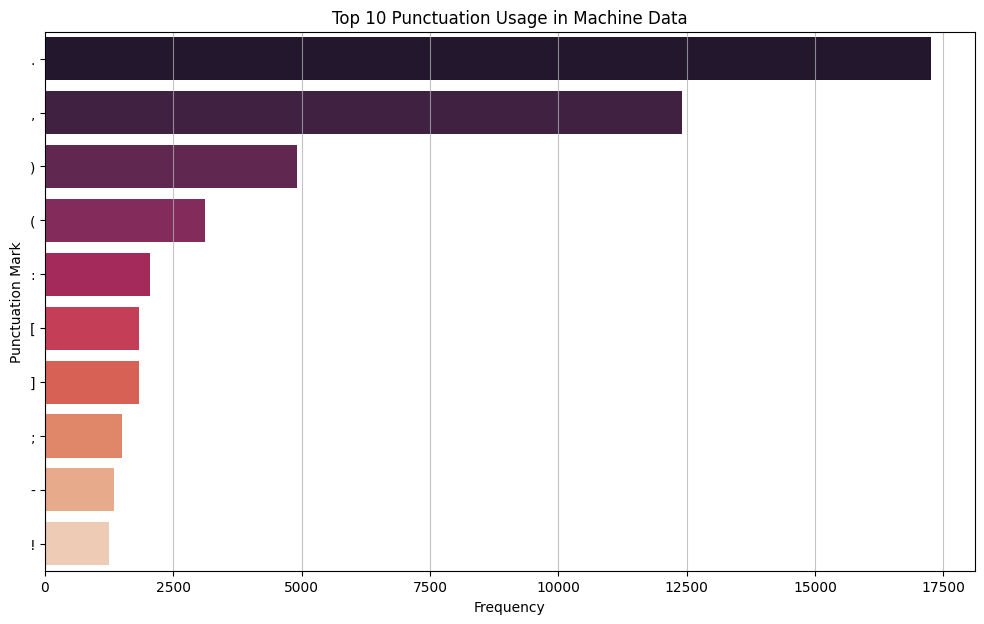

  Punctuation  Frequency
0           .      17254
1           ,      12411
2           )       4902
3           (       3126
4           :       2048
5           [       1836
6           ]       1828
7           ;       1505
8           -       1340
9           !       1241


In [59]:
human_punctuation_usage = analyze_punctuation_usage(human_df, "Human", top_n_punct=10)
print(human_punctuation_usage)
machine_punctuation_usage = analyze_punctuation_usage(machine_df, "Machine", top_n_punct=10)
print(machine_punctuation_usage)

In [62]:
def analyze_syntactic_complexity_metrics(df_to_analyze: pd.DataFrame, df_name: str) -> pd.DataFrame:
    all_word_lengths = []
    all_sentence_word_counts = []

    for text in df_to_analyze['text']:
        if not isinstance(text, str):
            continue

        sentences = sent_tokenize(text)
        for sentence in sentences:
            words = [word for word in word_tokenize(sentence) if word.isalpha()]
            if words:
                all_sentence_word_counts.append(len(words))
                for word in words:
                    all_word_lengths.append(len(word))

    results = {}
    if all_word_lengths:
        word_lengths_series = pd.Series(all_word_lengths)
        results['Average Word Length'] = word_lengths_series.mean()
        results['Median Word Length'] = word_lengths_series.median()
        results['Std Dev Word Length'] = word_lengths_series.std()

        plt.figure(figsize=(12, 6))
        sns.histplot(word_lengths_series, bins=30, color='skyblue')
        plt.title(f'Distribution of Word Lengths for {df_name} Data')
        plt.xlabel('Word Length (characters)')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        results['Average Word Length'] = 0
        results['Median Word Length'] = 0
        results['Std Dev Word Length'] = 0

    if all_sentence_word_counts:
        sentence_word_counts_series = pd.Series(all_sentence_word_counts)
        results['Average Sentence Length (words)'] = sentence_word_counts_series.mean()
        results['Median Sentence Length (words)'] = sentence_word_counts_series.median()
        results['Std Dev Sentence Length (words)'] = sentence_word_counts_series.std()

        plt.figure(figsize=(12, 6))
        sns.histplot(sentence_word_counts_series, bins=30, color='lightgreen')
        plt.title(f'Distribution of Sentence Lengths (words) for {df_name} Data')
        plt.xlabel('Sentence Length (words)')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        results['Average Sentence Length (words)'] = 0
        results['Median Sentence Length (words)'] = 0
        results['Std Dev Sentence Length (words)'] = 0

    return pd.DataFrame.from_dict(results, orient='index', columns=['Value'])


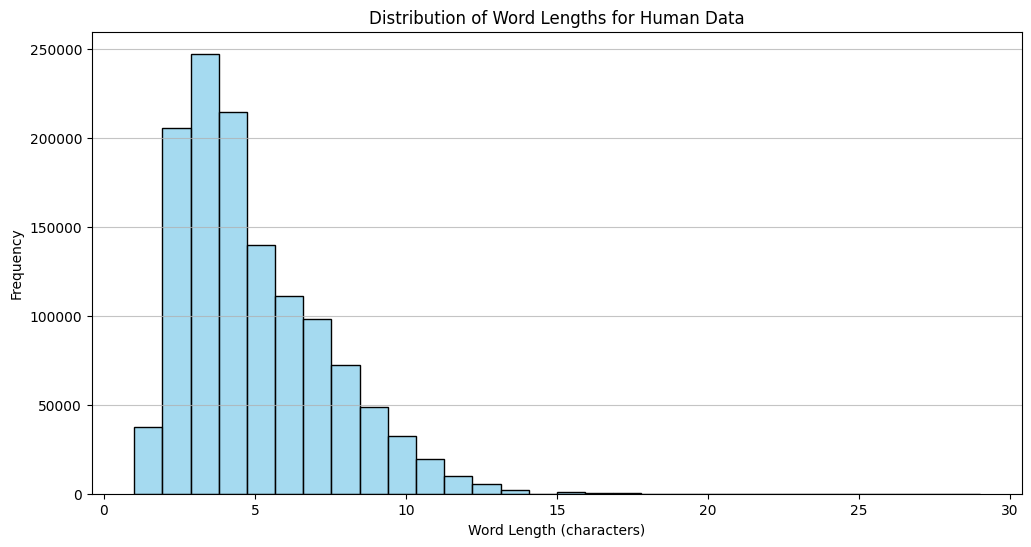

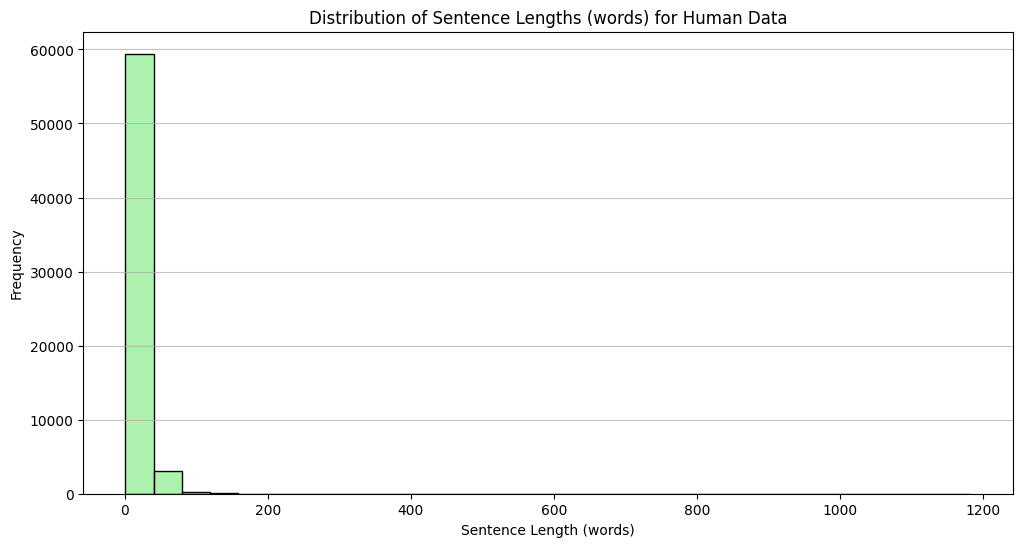

                                     Value
Average Word Length               4.732787
Median Word Length                4.000000
Std Dev Word Length               2.559895
Average Sentence Length (words)  19.824269
Median Sentence Length (words)   17.000000
Std Dev Sentence Length (words)  15.555842


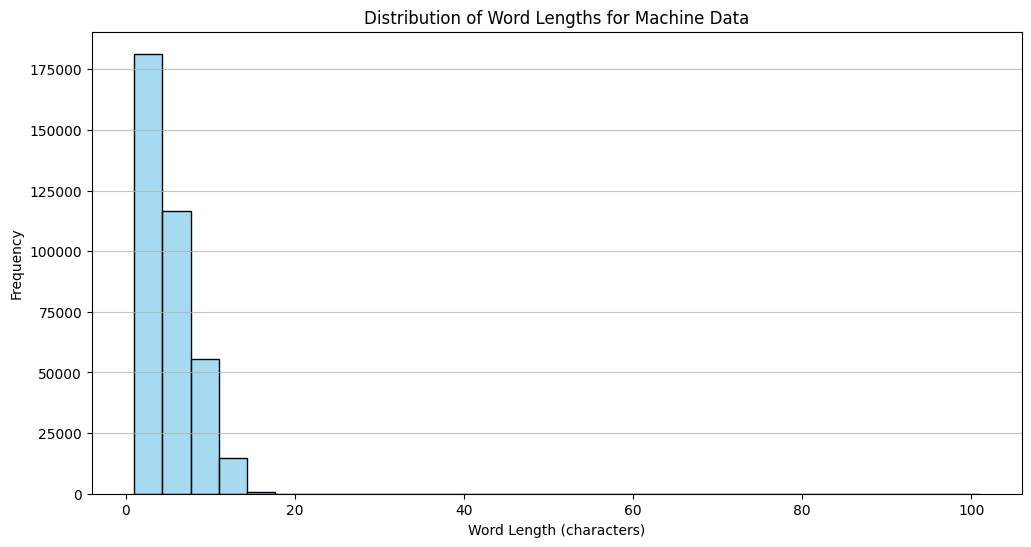

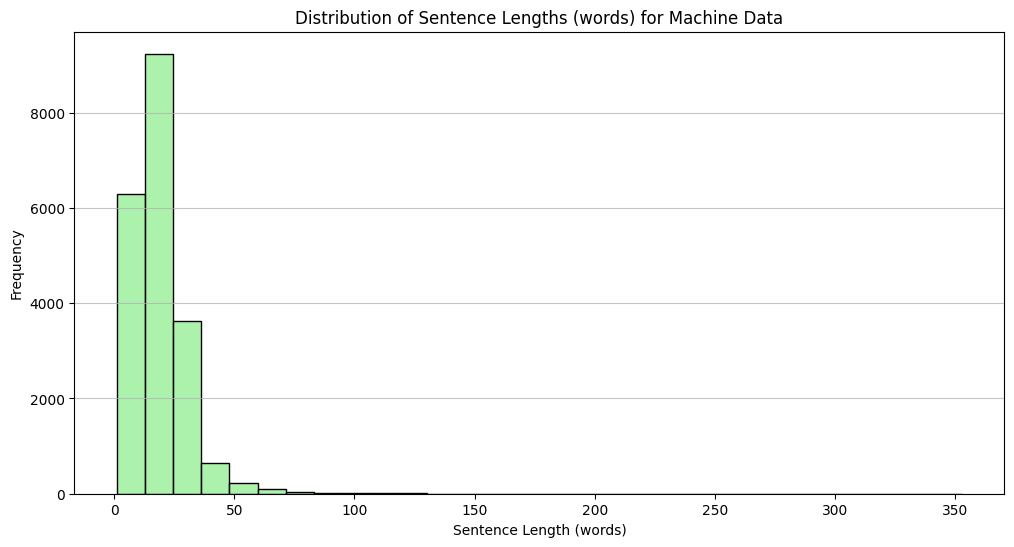

                                     Value
Average Word Length               5.161179
Median Word Length                5.000000
Std Dev Word Length               2.688930
Average Sentence Length (words)  18.277164
Median Sentence Length (words)   17.000000
Std Dev Sentence Length (words)  12.247508


In [63]:
human_syntactic_complexity = analyze_syntactic_complexity_metrics(human_df, "Human")
print(human_syntactic_complexity)
machine_syntactic_complexity = analyze_syntactic_complexity_metrics(machine_df, "Machine")
print(machine_syntactic_complexity)

Todos:

1. Describe every plot and statistic
2. Overlay human and machine plots on top of each other for better comparison

Other Metrics to explore:

- Readability Scores: Flesch Reading Ease, Flesch-Kincaid Grade Level, Gunning-Fog Index, SMOG Index, Coleman-Liau Index
- Hapax Legomena Ratio
- Rare Word Usage
- Parf of Speech Variety
- Topic Modeling Scores
- Word Embedding Comparison: Semantic Similarity between following sentences, Semantic Drift from beginning to end of text
- Errors and Fluency: Grammatical Errors, Repetition


In [14]:
# 3.5) Readability and Complexity Metrics
import textstat
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

def compute_metricss(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cal
    """



    # Calculate multiple readability metrics
    readability_metrics = []

    for idx, row in df.iterrows():
        text = row['text']

        metrics = {
            'index': idx,
            'label': row['label'],
            'model': row.get('model', 'unknown'),
            'source': row.get('source', 'unknown'),
            'flesch_reading_ease': textstat.flesch_reading_ease(text),
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'gunning_fog': textstat.gunning_fog(text),
            'coleman_liau_index': textstat.coleman_liau_index(text),
            'automated_readability_index': textstat.automated_readability_index(text),
            'smog_index': textstat.smog_index(text),
            'dale_chall_readability': textstat.dale_chall_readability_score(text)
        }
        readability_metrics = df.apply(compute_metrics, axis = 1)

        readability_df = pd.DataFrame(readability_metrics)

        # Plotting: Flesch Reading Ease by Label and Model
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=readability_df, x='label', y='flesch_reading_ease', hue='model')
        plt.title('Flesch Reading Ease by Label and Model')
        plt.xlabel('Label')
        plt.ylabel('Flesch Reading Ease Score')
        plt.legend(title='Model')
        plt.tight_layout()
        plt.show()

        return readability_df

In [23]:
# 3.5) Readability and Complexity Metrics

import textstat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_readability_metrics(df):
    """
    Compute multiple readability metrics and visualize Flesch Reading Ease.
    """

    # Calculate multiple readability metrics
    readability_metrics = []

    for idx, row in df.iterrows():
        text = row['text']

        # Skip empty, null ,or whitespace-only texts
        if pd.isna(text) or text.strip() == "":
            print(f"Skipping index {idx} due to empty or NaN text.")
            continue

        try:
            metrics = {
                'index': idx,
                'label': row['label'],
                'model': row.get('model', 'unknown'),
                'source': row.get('source', 'unknown'),
                'flesch_reading_ease': textstat.flesch_reading_ease(text),
                'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
                'gunning_fog': textstat.gunning_fog(text),
                'coleman_liau_index': textstat.coleman_liau_index(text),
                'automated_readability_index': textstat.automated_readability_index(text),
                'smog_index': textstat.smog_index(text),
                'dale_chall_readability': textstat.dale_chall_readability_score(text)
            }
            readability_metrics.append(metrics)

        except Exception as e:
            print(f"Error calculating readability for  index {idx}: {str(e)}")
            continue

    # Check if we have any valid data
    if not readability_metrics:
        raise ValueError("No valid readability metrics were computed. Check your input data.")

    readability_df = pd.DataFrame(readability_metrics)

    # Plotting: Flesch Reading Ease by Label and Model
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=readability_df, x='label', y='flesch_reading_ease', hue='model')
    plt.title('Flesch Reading Ease by Label and Model')
    plt.xlabel('Label')
    plt.ylabel('Flesch Reading Ease Score')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    return readability_df


In [24]:
human_readability_df = analyze_readability_metrics(human_df)
machine_readability_df = analyze_readability_metrics(machine_df)

NameError: name 'human_df' is not defined